# Chapter 12. k-nearest neighbors

In [ ]:
!jupyter labextension list

## 12.1 The model

Nearest neighbor is one of the simplest predictive models. It makes no mathematical assumptions, and it doesn't require any sort of heavy machinery. The only things it requires are:
1. Some notion of distance
2. An assumption that points that are close to one another are similar

Nearest neighbors quite consciously neglects a lot of information, since the prediction for each new point depends only on the handful of points closest to it 

Nearest neighbors is not going yo help understand the drivers of whatever phenomenon you are looking at

In [7]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a','b','c','b']) == 'b'

In [8]:
def majority_vote(labels: List[str]) -> str:
    '''Assumes that labels are ordered from nearest to farthest'''
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count 
                       for count in vote_counts.values()
                       if count == winner_count])
    if num_winners == 1:
        return winner 
    else:
        return majority_vote(labels[:-1])
    
assert majority_vote(['a','b','c','b','a']) == 'b'

In [9]:
from typing import NamedTuple 
from typing import List

Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

In [10]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int, 
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    # Order the labeled points from nearest to farthest 
    by_distance = sorted(labeled_points, 
                         key = lambda lp: distance(lp.point, new_point))
    
    # Find the labels for the k closest 
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    
    # Let them vote
    return majority_vote(k_nearest_labels)

## 12.2 Example: the iris dataset

In [83]:
import requests 

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.data', 'w') as f:
    f.write(data.text)

In [85]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    '''sepal_length, sepal_width, petal_length, petal_width, class'''
    measurements = [float(value) for value in row[:-1]]
    
    # class is e.g. Iris-virginica, we just want virginica
    label = row[-1].split("-")[1]
    
    return LabeledPoint(measurements, label)

with open("iris.data") as f:
    reader = csv.reader(f, delimiter = ',')
    iris_data = [parse_iris_row(row) for row in reader if len(row) >= 1]
    
points_by_species: Dict[str, List[Vector]] = defaultdict(list)

# group the points by species/label 
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

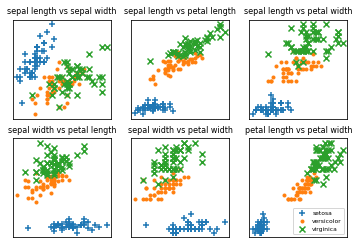

In [87]:
from matplotlib import pyplot as plt

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize = 8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker = mark, label = species)
ax[-1][-1].legend(loc = 'lower right', prop = {'size': 6})
plt.show()

In [95]:
import random 
from typing import TypeVar, List, Tuple

X = TypeVar('X') 

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

data = [n for n in range(1000)]
train, test = split_data(data, 0.75)

# The proportions should be correct
assert len(train) == 750
assert len(test) == 250

# And the original data should be preserved (in some order)
assert sorted(train + test) == data

def subtract(v: Vector, w: Vector) -> Vector:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"

    return [v_i - w_i for v_i, w_i in zip(v, w)]

In [96]:
random.seed(12)

iris_train, iris_test = split_data(iris_data, 0.7)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [97]:
from typing import Tuple 
import math

confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
    
    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## 12.3 The curse of dimensionality

The k-neatest neighbors algorithms runs into trouble in higher dimensions due to the curse of dimensionality. Points in high dimensional spaces tend not to be close to one another at all

In [98]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

In [99]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)

for dim in tqdm.tqdm(dimensions, desc = 'Curse of Dimensionality'):
    distances = random_distances(dim, 10000)
    avg_distances.append(sum(distances) / 10000)
    min_distances.append(min(distances))

Curse of Dimensionality: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


In [100]:
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]
min_avg_ratio

[2.4010264196729895e-05,
 0.012375993376885747,
 0.05866675835687187,
 0.052702840066952916,
 0.13806017036605744,
 0.16706667538692488,
 0.13946376694501153,
 0.21627918375769406,
 0.2584599213183403,
 0.269306360063673,
 0.27670626780046326,
 0.3706318741676572,
 0.26499940923263887,
 0.3552552587706282,
 0.3474871534632107,
 0.42834610882474056,
 0.42466657369159216,
 0.4446491710023277,
 0.535207240511332,
 0.34176993540037365,
 0.5388246061126235,
 0.5058621513898754,
 0.5347436432023157,
 0.5444461514254334,
 0.47597755191184377,
 0.4905464153431202,
 0.5867979218606769,
 0.5123632294260677,
 0.5424819954205379,
 0.5742090130686824,
 0.5897087379993046,
 0.5775736849502905,
 0.5673715611211803,
 0.5449292858365001,
 0.5796885476098184,
 0.6480053723471617,
 0.6602812580026879,
 0.6289471963191565,
 0.6418344464162202,
 0.6158132408201428,
 0.6091619742363008,
 0.664640030446849,
 0.6564359615197871,
 0.6539490799106948,
 0.6429102073843518,
 0.64757033619389,
 0.6497423009935857,

If you are trying to use nearest neighbors in higher dimensions, it is probably a good idea to do some kind of dimensionality reduction first

## 12.4 For further exploration

scikit-learn